In [1]:
#libs

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as m
import scipy.stats as scs
import matplotlib.pyplot as plt

%matplotlib inline

# *Load*

Columns Dictionary
- id -> user identification
- variants -> the website version the user see (A is control (show comments) and B is test (don't show comments))
- conversion -> if the user bought something (true or false)
- date -> the date

In [2]:
# load and put columns name in english

df = pd.read_csv('data/dataset.csv', encoding='utf-8').rename(columns={'variante':'variants', 
                                                                       'compra':'conversion', #if people buy
                                                                       'data':'date'})
df.head()

,id,variants,conversion,date
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


# *Exploratory Data Analysis*

In [3]:
print(f'Number of row: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of row: 55000
Number of columns: 4


In [4]:
# columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          55000 non-null  object
 1   variants    55000 non-null  object
 2   conversion  55000 non-null  bool  
 3   date        55000 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [5]:
# variants's and conversion's describe
df[['variants','conversion']].describe()

,variants,conversion
count,55000,55000
unique,2,2
top,A,False
freq,50000,46416


In [6]:
# check duplicates ids
df.id.value_counts().count()

55000

In [7]:
# check null values
pd.DataFrame({'Columns':df.isnull().sum().index,'Number of Null Values':df.isnull().sum().values})

,Columns,Number of Null Values
0,id,0
1,variants,0
2,conversion,0
3,date,0


In [8]:
# Number of unique values
pd.DataFrame({'Columns':df.nunique().index, 'Number of Unique Values':df.nunique().values})

,Columns,Number of Unique Values
0,id,55000
1,variants,2
2,conversion,2
3,date,395


In [9]:
# proportion per conversion and version 

freq_table_conv = df.conversion.value_counts()
pd.DataFrame({'Conversion': freq_table_conv.index, 'Quantity': freq_table_conv.values,
              '%': np.round(freq_table_conv.values/df.shape[0],3)*100})

,Conversion,Quantity,%
0,False,46416,84.4
1,True,8584,15.6


In [10]:
# information about the versions

freq_table_ver = df.variants.value_counts()
df_total = df.conversion
df_A = df[df.variants == 'A'].conversion
df_B = df[df.variants == 'B'].conversion

pd.DataFrame({'Version Names': list(freq_table_ver.index)+['Total'],
              'Quantity': list(freq_table_ver.values)+[freq_table_ver.values.sum()],
              '%': list(np.round(freq_table_ver.values/df.shape[0],3)*100)+[100],
              'Total Conversion': [df_A.sum(), df_B.sum(), df_total.sum()],
              'Conversion Probability': [df_A.mean(), df_B.mean(), df_total.mean()]})

,Version Names,Quantity,%,Total Conversion,Conversion Probability
0,A,50000,90.9,7603,0.152060
1,B,5000,9.1,981,0.196200
2,Total,55000,100.0,8584,0.156073


In [11]:
# Add Year-Month
df['YM'] = df['date'].apply(lambda row: row[:7])
df['D'] = df['date'].apply(lambda row: row[-2:])

## Table Pivot

Per Day

In [12]:
df_pivot_plate = df.pivot_table(index = ['D'], columns = ['variants'], values=['conversion'], aggfunc=np.mean)
df_pivot_plate = df_pivot_plate.fillna(0)
df_pivot_plate

conversion          
variants          A         B
D                            
01         0.143981  0.206250
02         0.152595  0.221622
03         0.153611  0.172043
04         0.145200  0.193548
05         0.161094  0.197531
06         0.149739  0.220238
07         0.153231  0.214286
08         0.147311  0.134146
09         0.160000  0.201117
10         0.153751  0.153846
11         0.155611  0.200000
12         0.143025  0.216667
13         0.148104  0.173913
14         0.157276  0.166667
15         0.169755  0.230769
16         0.153940  0.189189
17         0.156020  0.192053
18         0.155852  0.248588
19         0.163342  0.193103
20         0.150464  0.160000
21         0.151442  0.215278
22         0.177238  0.164474
23         0.148688  0.223602
24         0.139021  0.186047
25         0.142154  0.209424
26         0.145999  0.209945
27         0.137290  0.150289
28         0.147551  0.184524
29         0.144841  0.262821
30         0.150649  0.197674
31         0.157542  0.000000

Per Year-Month

In [13]:
df_pivot_date = df.pivot_table(index = ['YM'], columns = ['variants'], values=['conversion'], aggfunc=np.sum)
df_pivot_date = df_pivot_date.fillna(0)
df_pivot_date

conversion       
variants          A      B
YM                        
2019-01       634.0    0.0
2019-02       539.0    0.0
2019-03       619.0    0.0
2019-04       544.0    0.0
2019-05       606.0    0.0
2019-06       581.0    0.0
2019-07       615.0    0.0
2019-08       579.0    0.0
2019-09       621.0    0.0
2019-10       558.0    0.0
2019-11       547.0    0.0
2019-12       573.0    0.0
2020-01       587.0  981.0

# *1. Some configurations*

### Data Munging

In [14]:
# using just data from January/2020
df_2020 = df[df['YM'] == '2020-01']
df_2020.head()

,id,variants,conversion,date,YM,D
5,0x792f1d,A,False,2020-01-14,2020-01,14
7,0x724b78,B,False,2020-01-23,2020-01,23
9,0x684bf9,A,False,2020-01-17,2020-01,17
10,0x6394dc,A,False,2020-01-06,2020-01,06
11,0x625f5d,A,False,2020-01-05,2020-01,05


### Base Line

In [18]:
# information about the versions

freq_table_ver = df_2020.variants.value_counts()
df_total = df_2020.conversion
df_A = df_2020[df_2020.variants == 'A'].conversion
df_B = df_2020[df_2020.variants == 'B'].conversion

df_base_line = pd.DataFrame({'Version Names': freq_table_ver.index,
                             'Quantity': freq_table_ver.values,
                             '%': np.round(freq_table_ver.values/df.shape[0],3)*100,
                             'Total Conversion': [df_B.sum(), df_A.sum()],
                             'Conversion Probability': [df_B.mean(), df_A.mean()]})
df_base_line

,Version Names,Quantity,%,Total Conversion,Conversion Probability
0,B,5000,9.1,981,0.196200
1,A,3821,6.9,587,0.153625


In [19]:
# Summary of Base Line

conversion_A = df_base_line['Total Conversion'][1]
conversion_B = df_base_line['Total Conversion'][0]

total_A = df_base_line['Quantity'][1]
total_B = df_base_line['Quantity'][0]

rate_A = df_base_line['Conversion Probability'][1]
rate_B = df_base_line['Conversion Probability'][0]

conversion_base = rate_A
effect_minimum = rate_B - rate_A # Minimum Detectable Effect

# *2. Hypothesis Test*

$p_{A}$ and $p_{B}$ being the conversion probabilities for the new and old variants, the hypotheses are defined in terms of words or in notation as:

- H0: PB - PA = 0 (difference in probability of the two groups is equal to zero)
- H1: PB - PA > 0 (difference in probability of the two groups is greater than zero)

Parameters:
- Alfa (Significance Level) $\alpha$: normally 5%; probability of rejecting the null hypothesis when the null hypothesis is true
- Beta $\beta$: probability of accepting the null hypothesis when the null hypothesis is really false.
- Size $n$: sample size

In [20]:
alfa = 0.05
beta = 0.2
n = 50000

We can assume that the distribution of our control group is binomial because the data is a series of attempts by Bernoulli, in which each attempt has only two possible outcomes (similar to a heads or tails).

So, we will user the Binomial Test.

In [21]:
# Binomial Test (usando padrão de 5% para o nível de significância)
teste_binom = scs.binom(n, p=conversion_base)
teste_binom

In [22]:
# Teste Binomial com o efeito mínimo (no nosso exemplo 0.04 para o nível de significância)
teste_binom_mde = scs.binom(n, p=conversion_base+effect_minimum)
teste_binom_mde

<BarContainer object of 8822 artists>

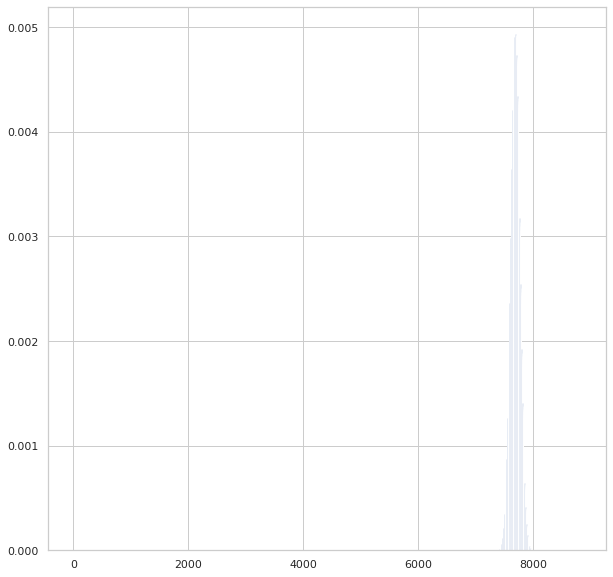

In [36]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(style="whitegrid")

# x values
x = np.linspace(0, int(n), int(n) + 1)

# pmf e alfa de 0.5
ax.bar(x, teste_binom.pmf(x), alpha = 0.5)
ax.bar(x, teste_binom_mde.pmf(x), alpha = 0.5)

# *3. Distribution Plot*

Graph of the distribution of both variants. It is noticed that B has a higher number of conversions but A has a higher probability of conversion. We will focus on the conversion rate; to be able to compare both variants, we must standardize the data.

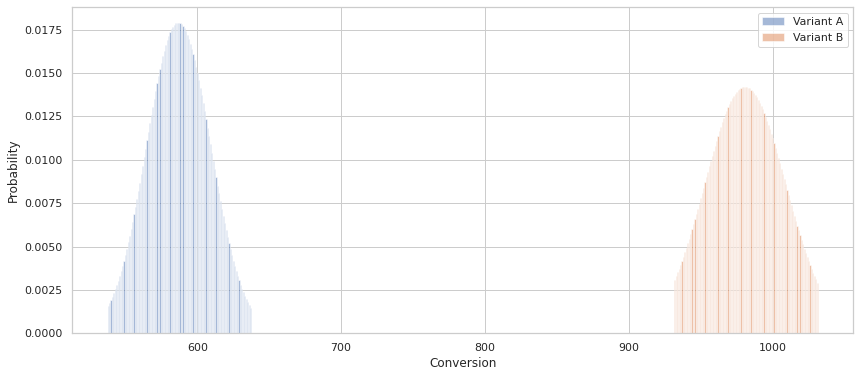

In [25]:
# plot
fig, ax = plt.subplots(figsize=(14,6))
sns.set_theme(style="whitegrid")

# graphic A
xA = np.linspace(conversion_A-49, conversion_A+50, 100)
yA = scs.binom(total_A, rate_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5, label='Variant A')
ax.legend()

# graphic B
xB = np.linspace(conversion_B-49, conversion_B+50, 100)
yB = scs.binom(total_B, rate_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5, label='Variant B')
ax.legend()

# labels
plt.xlabel('Conversion')
plt.ylabel('Probability')
plt.show()

### Padronization and Plot

**Null Hypothesis (H0):** will be a normal distribution with an average of zero and a standard deviation equal to the standard error pooled.

**Alternative Hypothesis (H1):** has the same standard deviation as the null hypothesis, but the mean will be located in the difference in the conversion rate, d_hat.

In [26]:
# probabilities
p_A = rate_A
p_B = rate_B

# number of conversion
N_A = total_A
N_B = total_B

In [27]:
# pooled probability for 2 samples
def pooled_prob_func(N_A, N_B, X_A, X_B):
    return (X_A + X_B) / (N_A + N_B)

# pooled standard error for 2 samples
def pooled_std_err_func(N_A, N_B, X_A, X_B):
    p_hat = pooled_prob_func(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1-p_hat) * (1/N_A + 1/N_B))
    return SE

In [28]:
# Z value for a given level of significance
def z_val(sig_level=0.05, two_tailed=True):
    
    # get distribution
    z_dist = scs.norm()
    
    # check if one or tow tails
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    # z values
    z = z_dist.ppf(area)

    return z

# confidence interval
def confidence_interval(sample_mean=0, sample_std=1, sample_size=1, sig_level=0.05):
    
    # get z value
    z = z_val(sig_level)

    # right and left limits
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

# confidence interval plot
def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):

    # get confidence interval
    left, right = confidence_interval(sample_mean=mu, sample_std=s, sig_level=sig_level)
    
    # put in the plot
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)

In [29]:
# normal distribuition plot
def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):

    # get data
    x = np.linspace(mu-12*std, mu+12*std, 1000)
    y = scs.norm(mu, std).pdf(x)
    
    # plot
    ax.plot(x, y, label=label)

    # put CI in the plot, if there is one
    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)
        
def plot_H0(ax, stderr):
    plot_norm_dist(ax, 0, stderr, label="H0 - Null Hypothesis")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)

def plot_H1(ax, stderr, d_hat):
    plot_norm_dist(ax, d_hat, stderr, label="H1 - Alternative Hypothesis")

In [30]:
def show_area(ax, d_hat, stderr, sig_level):

    # confidence interval
    left, right = confidence_interval(sample_mean=0, sample_std=stderr, sig_level=sig_level)
    
    # variable x
    x = np.linspace(-12*stderr, 12*stderr, 1000)
    
    # H0 e H1
    null = ab_dist(stderr, 'controle')
    alternative = ab_dist(stderr, d_hat, 'teste')

    sts_pwe = np.round(1-alternative.cdf(right),3)
    ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha=0.25, where=(x>right))
    ax.text(-2*stderr, null.pdf(0), f'power = {sts_pwe}', 
            fontsize=12, ha='right', color='k')

In [31]:
# Função que retorna um objeto de distribuição dependendo do tipo de grupo
def ab_dist(stderr, d_hat=0, group_type='controle'):

    # check group type
    if group_type == 'controle':
        sample_mean = 0
    elif group_type == 'teste':
        sample_mean = d_hat

    # creat normal distribuition
    dist = scs.norm(sample_mean, stderr)
    return dist

# p value
def p_val(N_A, N_B, p_A, p_B):
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [32]:
def abplot_func(N_A, N_B, bcr, d_hat, sig_level=0.05, show_p_value=False, show_legend=True):
   
    # plot
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.set_theme(style="whitegrid")

    # pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_std_err_func(N_A, N_B, X_A, X_B)

    # H0 e H1 plot
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)

    # plot configs
    ax.set_xlim(-8*stderr, 8*stderr)
    show_area(ax, d_hat, stderr, sig_level)

    # put p value in the plot
    if show_p_value:
        null = ab_dist(stderr, 'controle')
        p_value = p_val(N_A, N_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), f'Valor-p = {np.round(p_value,4)}', fontsize = 14, ha = 'left')

    # show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

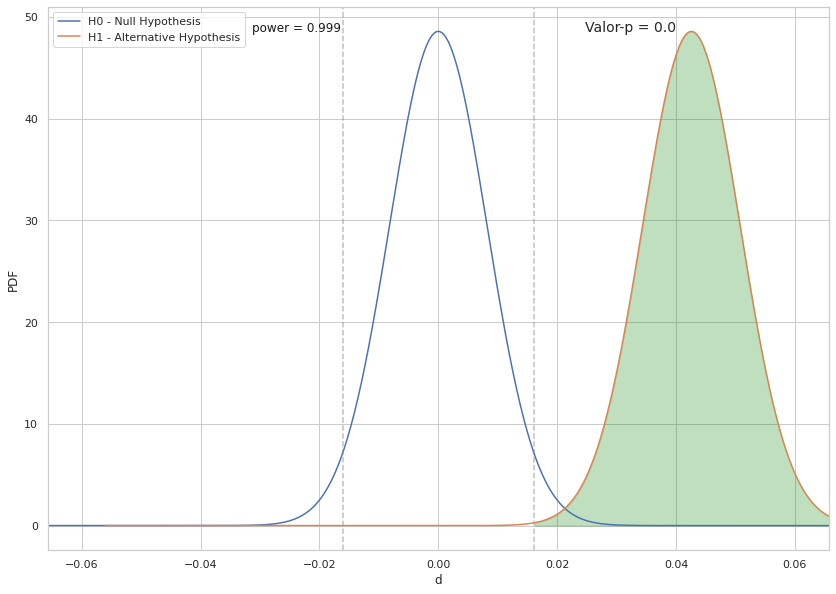

In [33]:
# creat plot
n = N_A + N_B
conversion_base = p_A  
d_hat = p_B - p_A
abplot_func(N_A, N_B, conversion_base, d_hat, show_p_value=True)

Now with both standardized hypotheses, we can compare it without any problem. We see that the average conversion rate of the alternative hypothesis remains higher, so we can suggest that the test group has a higher conversion rate than the control group.

# *4. Statistical Power*

The Statistical Power is calculated by finding the area under the alternative hypothesis distribution and outside the confidence interval of the null hypothesis. In the graphic, the green area is the area we are looking and the dashed lines are confidence intervals.

For this, we will use the CDF, which the distribution of the alternative hypothesis generated, to calculate this value. 

** You can find the operation in function **show_area()** above.

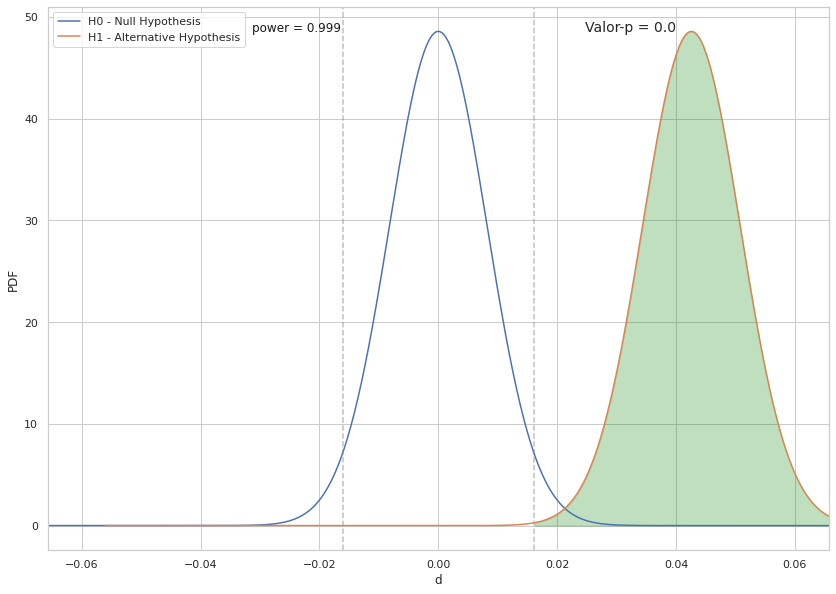

In [37]:
abplot_func(N_A, N_B, conversion_base, d_hat, show_p_value=True)

# *5. Minimun Sample Size*

The sample size is a important part, if you add or remove data, the combined variance can change. Let's see with 1500 and 2500.

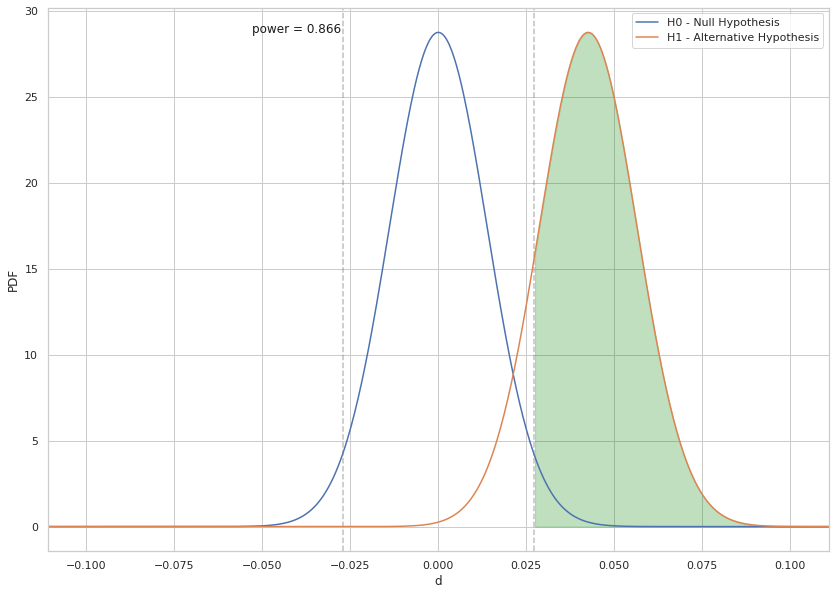

In [39]:
# with size 1500
abplot_func(1500, 1500, conversion_base, d_hat)

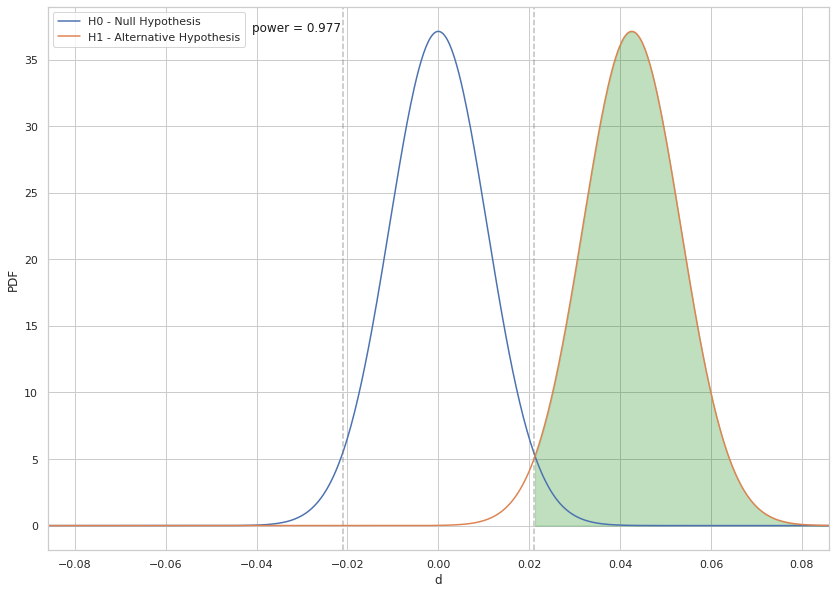

In [41]:
# with size 2500
abplot_func(2500, 2500, conversion_base, d_hat)

Now, let's find what is the minimum sample size for get a statistics power over 80%. To do that, we will code in the cell below the following formula.

$$ n_A = k*n_B $$

$$ n_B = (\frac{p_A(1-p_A)}{k}+p_B(1-p_B)) (\frac{Z_{1-\alpha} + Z_{1-\beta}}{p_A-p_B})^{2}$$

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_{1-\beta}+Z_{1-\alpha})^2}{(p_B-p_A)^2}$$



In [51]:
def min_sample_size(N_A, N_B, p_A, p_B, power=0.8, sig_level=0.05, two_sided=False):
    
    # get z beta
    standard_norm = scs.norm(0, 1)
    Z_beta = standard_norm.ppf(power)
    
    # get z alfa
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # poopled probability
    pooled_prob = (p_A + p_B) / 2

    # minimum sample size
    min_N = int((2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / effect_minimum**2))

    return min_N

In [52]:
# get minimum size
min_size = min_sample_size(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)
min_size

1249

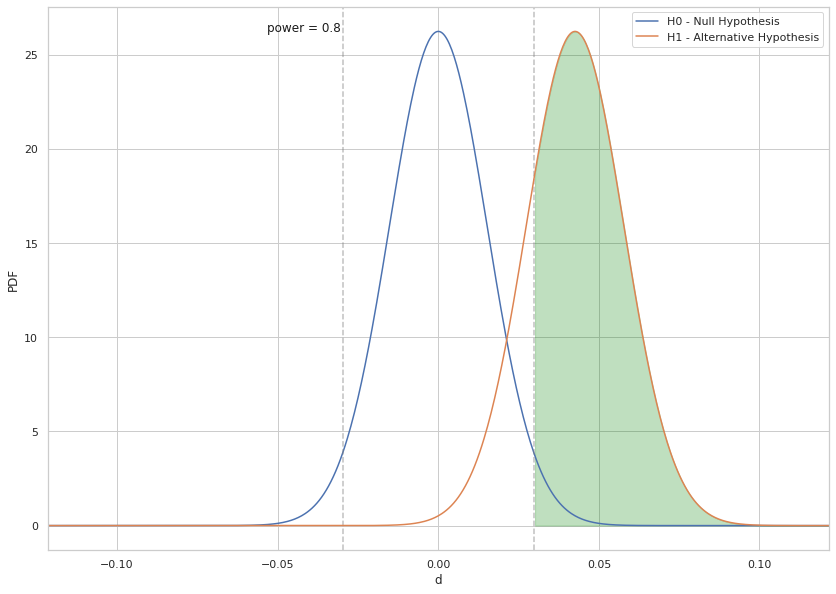

In [53]:
# plot
abplot_func(N_A=min_size, N_B=min_size, bcr=p_A, d_hat=p_B-p_A, 
            sig_level=0.05, show_p_value=False, show_legend=True)

# *Final Considerations*


With the calculated statistical power (0.99) and the minimum sample size to achieve power greater than 0.8 calculated (1249), we were able to show that variant B is better than A.